
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_fake
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, hidden_size=hidden_size)

    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size, 
                                reuse=True)
    # print('Qs.shape, nextQs.shape, nextQs_fake.shape, nextQs_real.shape:',
    #       Qs.shape, nextQs.shape, nextQs_fake.shape, nextQs_real.shape)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_fake2 + g_loss_real

    # Discriminator loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                         labels=tf.zeros_like(nextQs)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.nn.sigmoid(nextQs)))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [10]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [14]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 8 Training g_loss: 1.9845 Training d_loss: 1.3348 Explore P: 0.9992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18 Training g_loss: 1.9877 Training d_loss: 1.2285 Explore P: 0.9974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 18 Training g_loss: 2.1674 Training d_loss: 1.2072 Explore P: 0.9957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 14 Training g_loss: 2.2918 Training d_loss: 1.1525 Explore P: 0.9943
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 32 Training g_loss: 2.0583 Training d_loss: 1.2164 Explore P: 0.9299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 11 Training g_loss: 2.0297 Training d_loss: 1.2914 Explore P: 0.9289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 18 Training g_loss: 2.1419 Training d_loss: 1.2354 Explore P: 0.9273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 12 Training g_loss: 2.3422 Training d_loss: 1.2149 Explore P: 0.9262
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 18 Training g_loss: 2.1539 Training d_loss: 1.2498 Explore P: 0.8608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 24 Training g_loss: 2.0801 Training d_loss: 1.2804 Explore P: 0.8588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 10 Training g_loss: 2.0589 Training d_loss: 1.2613 Explore P: 0.8579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 11 Training g_loss: 2.0438 Training d_loss: 1.2125 Explore P: 0.8570
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 23 Training g_loss: 2.0145 Training d_loss: 1.2738 Explore P: 0.8053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 17 Training g_loss: 1.9621 Training d_loss: 1.3012 Explore P: 0.8039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 41 Training g_loss: 1.9990 Training d_loss: 1.3105 Explore P: 0.8007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 25 Training g_loss: 2.0285 Training d_loss: 1.2764 Explore P: 0.7987
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 134 Total reward: 7 Training g_loss: 1.9964 Training d_loss: 1.2666 Explore P: 0.7456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 48 Training g_loss: 1.9440 Training d_loss: 1.3159 Explore P: 0.7421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 9 Training g_loss: 1.9565 Training d_loss: 1.3148 Explore P: 0.7414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 27 Training g_loss: 1.9237 Training d_loss: 1.3305 Explore P: 0.7395
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 168 Total reward: 18 Training g_loss: 1.9409 Training d_loss: 1.3055 Explore P: 0.7049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 13 Training g_loss: 1.9659 Training d_loss: 1.2911 Explore P: 0.7040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 170 Total reward: 10 Training g_loss: 1.9550 Training d_loss: 1.2877 Explore P: 0.7033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 171 Total reward: 21 Training g_loss: 1.9459 Training d_loss: 1.2977 Explore P: 0.7019
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 201 Total reward: 25 Training g_loss: 1.9568 Training d_loss: 1.2972 Explore P: 0.6592
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 26 Training g_loss: 1.9327 Training d_loss: 1.3183 Explore P: 0.6575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 16 Training g_loss: 1.9461 Training d_loss: 1.3158 Explore P: 0.6565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 11 Training g_loss: 1.9424 Training d_loss: 1.3035 Explore P: 0.6557
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 234 Total reward: 23 Training g_loss: 1.9322 Training d_loss: 1.3221 Explore P: 0.6239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 10 Training g_loss: 1.9308 Training d_loss: 1.3183 Explore P: 0.6233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 21 Training g_loss: 1.9447 Training d_loss: 1.2991 Explore P: 0.6220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 237 Total reward: 9 Training g_loss: 1.9583 Training d_loss: 1.2870 Explore P: 0.6214
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 267 Total reward: 23 Training g_loss: 2.1392 Training d_loss: 1.2156 Explore P: 0.5903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 34 Training g_loss: 2.0213 Training d_loss: 1.2957 Explore P: 0.5883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 57 Training g_loss: 1.9674 Training d_loss: 1.3004 Explore P: 0.5850
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 10 Training g_loss: 1.9819 Training d_loss: 1.3044 Explore P: 0.5844
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 300 Total reward: 18 Training g_loss: 1.9208 Training d_loss: 1.3536 Explore P: 0.5615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 9 Training g_loss: 1.9348 Training d_loss: 1.3460 Explore P: 0.5610
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 17 Training g_loss: 1.9634 Training d_loss: 1.2968 Explore P: 0.5600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 15 Training g_loss: 1.9437 Training d_loss: 1.3102 Explore P: 0.5592
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 34 Training g_loss: 1.9605 Training d_loss: 1.2894 Explore P: 0.5279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 10 Training g_loss: 1.9518 Training d_loss: 1.2975 Explore P: 0.5274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 13 Training g_loss: 1.9498 Training d_loss: 1.2909 Explore P: 0.5267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 9 Training g_loss: 1.9567 Training d_loss: 1.2941 Explore P: 0.5263
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 366 Total reward: 10 Training g_loss: 2.1038 Training d_loss: 1.2831 Explore P: 0.5028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 24 Training g_loss: 2.0294 Training d_loss: 1.2981 Explore P: 0.5016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 13 Training g_loss: 1.9929 Training d_loss: 1.3384 Explore P: 0.5010
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 10 Training g_loss: 1.9955 Training d_loss: 1.3247 Explore P: 0.5005
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 399 Total reward: 23 Training g_loss: 1.9252 Training d_loss: 1.3210 Explore P: 0.4801
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 7 Training g_loss: 1.9245 Training d_loss: 1.3219 Explore P: 0.4798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 18 Training g_loss: 1.9353 Training d_loss: 1.3156 Explore P: 0.4789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 12 Training g_loss: 1.9499 Training d_loss: 1.2965 Explore P: 0.4783
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 432 Total reward: 14 Training g_loss: 1.9536 Training d_loss: 1.3015 Explore P: 0.4558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 15 Training g_loss: 1.9079 Training d_loss: 1.3471 Explore P: 0.4551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 40 Training g_loss: 1.9879 Training d_loss: 1.2583 Explore P: 0.4534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 14 Training g_loss: 1.9763 Training d_loss: 1.2733 Explore P: 0.4527
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 465 Total reward: 32 Training g_loss: 1.9340 Training d_loss: 1.3383 Explore P: 0.4305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 11 Training g_loss: 1.9231 Training d_loss: 1.3334 Explore P: 0.4300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 9 Training g_loss: 1.9698 Training d_loss: 1.2850 Explore P: 0.4296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 42 Training g_loss: 1.9584 Training d_loss: 1.3285 Explore P: 0.4279
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 499 Total reward: 9 Training g_loss: 1.9621 Training d_loss: 1.2947 Explore P: 0.4061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 9 Training g_loss: 1.9621 Training d_loss: 1.2933 Explore P: 0.4057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 24 Training g_loss: 1.9474 Training d_loss: 1.3039 Explore P: 0.4048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 11 Training g_loss: 1.9508 Training d_loss: 1.2990 Explore P: 0.4043
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 532 Total reward: 15 Training g_loss: 1.9549 Training d_loss: 1.2991 Explore P: 0.3895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 8 Training g_loss: 1.9439 Training d_loss: 1.3030 Explore P: 0.3892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 28 Training g_loss: 1.9454 Training d_loss: 1.3019 Explore P: 0.3881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 15 Training g_loss: 1.9523 Training d_loss: 1.3038 Explore P: 0.3876
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 565 Total reward: 20 Training g_loss: 2.1093 Training d_loss: 1.2120 Explore P: 0.3721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 8 Training g_loss: 2.0505 Training d_loss: 1.2471 Explore P: 0.3718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 29 Training g_loss: 1.9841 Training d_loss: 1.3222 Explore P: 0.3708
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 9 Training g_loss: 1.9674 Training d_loss: 1.3194 Explore P: 0.3704
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 599 Total reward: 12 Training g_loss: 1.9406 Training d_loss: 1.2983 Explore P: 0.3577
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 8 Training g_loss: 1.9607 Training d_loss: 1.2801 Explore P: 0.3574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 7 Training g_loss: 1.9611 Training d_loss: 1.2843 Explore P: 0.3571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 31 Training g_loss: 1.9335 Training d_loss: 1.3102 Explore P: 0.3561
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 633 Total reward: 17 Training g_loss: 1.9777 Training d_loss: 1.2810 Explore P: 0.3423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 10 Training g_loss: 2.0299 Training d_loss: 1.2311 Explore P: 0.3420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 11 Training g_loss: 2.0311 Training d_loss: 1.2351 Explore P: 0.3416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 8 Training g_loss: 1.9973 Training d_loss: 1.2622 Explore P: 0.3413
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 666 Total reward: 9 Training g_loss: 1.9388 Training d_loss: 1.3293 Explore P: 0.3272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 8 Training g_loss: 1.9575 Training d_loss: 1.3053 Explore P: 0.3269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 8 Training g_loss: 1.9671 Training d_loss: 1.2965 Explore P: 0.3267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 12 Training g_loss: 1.9670 Training d_loss: 1.2922 Explore P: 0.3263
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 699 Total reward: 19 Training g_loss: 1.9578 Training d_loss: 1.3172 Explore P: 0.3153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 15 Training g_loss: 1.9955 Training d_loss: 1.2885 Explore P: 0.3148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 9 Training g_loss: 2.0029 Training d_loss: 1.2775 Explore P: 0.3146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 10 Training g_loss: 1.9841 Training d_loss: 1.2859 Explore P: 0.3143
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 732 Total reward: 16 Training g_loss: 1.9167 Training d_loss: 1.3316 Explore P: 0.3031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 733 Total reward: 32 Training g_loss: 1.9791 Training d_loss: 1.2658 Explore P: 0.3022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 9 Training g_loss: 1.9869 Training d_loss: 1.2592 Explore P: 0.3019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 33 Training g_loss: 1.9812 Training d_loss: 1.2665 Explore P: 0.3009
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 766 Total reward: 33 Training g_loss: 1.9333 Training d_loss: 1.3112 Explore P: 0.2891
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 23 Training g_loss: 1.9233 Training d_loss: 1.3128 Explore P: 0.2884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 15 Training g_loss: 1.9234 Training d_loss: 1.3184 Explore P: 0.2880
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 8 Training g_loss: 1.9291 Training d_loss: 1.3229 Explore P: 0.2878
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 799 Total reward: 9 Training g_loss: 1.9323 Training d_loss: 1.3009 Explore P: 0.2761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 12 Training g_loss: 1.9537 Training d_loss: 1.3023 Explore P: 0.2758
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 14 Training g_loss: 1.9373 Training d_loss: 1.2956 Explore P: 0.2754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 9 Training g_loss: 1.9437 Training d_loss: 1.2955 Explore P: 0.2752
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 833 Total reward: 16 Training g_loss: 1.9469 Training d_loss: 1.2929 Explore P: 0.2634
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 18 Training g_loss: 1.9219 Training d_loss: 1.3302 Explore P: 0.2629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 9 Training g_loss: 1.9211 Training d_loss: 1.3127 Explore P: 0.2627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 19 Training g_loss: 1.9856 Training d_loss: 1.2706 Explore P: 0.2622
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 866 Total reward: 21 Training g_loss: 1.9736 Training d_loss: 1.2756 Explore P: 0.2518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 11 Training g_loss: 1.9436 Training d_loss: 1.2938 Explore P: 0.2515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 21 Training g_loss: 1.9256 Training d_loss: 1.3259 Explore P: 0.2510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 21 Training g_loss: 1.9393 Training d_loss: 1.3040 Explore P: 0.2505
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 900 Total reward: 12 Training g_loss: 1.9180 Training d_loss: 1.3353 Explore P: 0.2420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 8 Training g_loss: 1.9212 Training d_loss: 1.3173 Explore P: 0.2419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 8 Training g_loss: 1.9201 Training d_loss: 1.3181 Explore P: 0.2417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 31 Training g_loss: 1.9402 Training d_loss: 1.3039 Explore P: 0.2410
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 934 Total reward: 10 Training g_loss: 2.0217 Training d_loss: 1.2803 Explore P: 0.2319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 16 Training g_loss: 2.0014 Training d_loss: 1.2890 Explore P: 0.2315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 15 Training g_loss: 1.9337 Training d_loss: 1.3239 Explore P: 0.2312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 10 Training g_loss: 1.9314 Training d_loss: 1.3216 Explore P: 0.2310
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 968 Total reward: 14 Training g_loss: 2.1763 Training d_loss: 1.2729 Explore P: 0.2224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 9 Training g_loss: 2.1900 Training d_loss: 1.3165 Explore P: 0.2222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 7 Training g_loss: 2.0839 Training d_loss: 1.3465 Explore P: 0.2220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 7 Training g_loss: 2.0200 Training d_loss: 1.3471 Explore P: 0.2219
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1002 Total reward: 12 Training g_loss: 1.9324 Training d_loss: 1.3016 Explore P: 0.2138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1003 Total reward: 8 Training g_loss: 1.9359 Training d_loss: 1.2965 Explore P: 0.2137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1004 Total reward: 10 Training g_loss: 1.9348 Training d_loss: 1.2970 Explore P: 0.2135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1005 Total reward: 13 Training g_loss: 1.9292 Training d_loss: 1.2985 Explore P: 0.2132
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1034 Total reward: 10 Training g_loss: 1.9434 Training d_loss: 1.2841 Explore P: 0.2064
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1035 Total reward: 11 Training g_loss: 1.9498 Training d_loss: 1.2930 Explore P: 0.2061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1036 Total reward: 11 Training g_loss: 1.9590 Training d_loss: 1.2972 Explore P: 0.2059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1037 Total reward: 9 Training g_loss: 1.9532 Training d_loss: 1.3018 Explore P: 0.2057
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1066 Total reward: 13 Training g_loss: 1.9508 Training d_loss: 1.2989 Explore P: 0.1988
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 14 Training g_loss: 1.8739 Training d_loss: 1.3760 Explore P: 0.1985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 18 Training g_loss: 1.8987 Training d_loss: 1.3322 Explore P: 0.1982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 9 Training g_loss: 1.9192 Training d_loss: 1.3204 Explore P: 0.1980
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1098 Total reward: 11 Training g_loss: 1.9879 Training d_loss: 1.2560 Explore P: 0.1919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 15 Training g_loss: 1.9582 Training d_loss: 1.2889 Explore P: 0.1917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1100 Total reward: 19 Training g_loss: 1.9004 Training d_loss: 1.3380 Explore P: 0.1913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1101 Total reward: 17 Training g_loss: 1.9361 Training d_loss: 1.3143 Explore P: 0.1910
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1131 Total reward: 8 Training g_loss: 1.9450 Training d_loss: 1.2976 Explore P: 0.1841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 8 Training g_loss: 1.9291 Training d_loss: 1.3075 Explore P: 0.1840
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1133 Total reward: 7 Training g_loss: 1.9307 Training d_loss: 1.3041 Explore P: 0.1839
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1134 Total reward: 9 Training g_loss: 1.9240 Training d_loss: 1.3052 Explore P: 0.1837
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1163 Total reward: 9 Training g_loss: 1.9106 Training d_loss: 1.3750 Explore P: 0.1774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1164 Total reward: 9 Training g_loss: 1.8774 Training d_loss: 1.4022 Explore P: 0.1773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1165 Total reward: 9 Training g_loss: 1.8618 Training d_loss: 1.4188 Explore P: 0.1771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1166 Total reward: 9 Training g_loss: 1.8938 Training d_loss: 1.3925 Explore P: 0.1770
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1195 Total reward: 13 Training g_loss: 1.9295 Training d_loss: 1.3137 Explore P: 0.1714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 7 Training g_loss: 1.9379 Training d_loss: 1.3053 Explore P: 0.1713
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1197 Total reward: 9 Training g_loss: 1.9410 Training d_loss: 1.3073 Explore P: 0.1711
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 10 Training g_loss: 1.9253 Training d_loss: 1.3133 Explore P: 0.1710
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 18 Training g_loss: 1.9522 Training d_loss: 1.2761 Explore P: 0.1657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 10 Training g_loss: 1.9441 Training d_loss: 1.2899 Explore P: 0.1656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 8 Training g_loss: 1.9390 Training d_loss: 1.2959 Explore P: 0.1654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 17 Training g_loss: 1.9502 Training d_loss: 1.2811 Explore P: 0.1652
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1260 Total reward: 10 Training g_loss: 1.9627 Training d_loss: 1.2907 Explore P: 0.1584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 20 Training g_loss: 1.9340 Training d_loss: 1.3152 Explore P: 0.1581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1262 Total reward: 15 Training g_loss: 1.8824 Training d_loss: 1.3578 Explore P: 0.1579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1263 Total reward: 10 Training g_loss: 1.8792 Training d_loss: 1.3677 Explore P: 0.1577
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1293 Total reward: 7 Training g_loss: 1.7975 Training d_loss: 1.5351 Explore P: 0.1516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1294 Total reward: 9 Training g_loss: 1.8577 Training d_loss: 1.4290 Explore P: 0.1515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1295 Total reward: 12 Training g_loss: 1.9636 Training d_loss: 1.2933 Explore P: 0.1513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1296 Total reward: 9 Training g_loss: 2.0510 Training d_loss: 1.2176 Explore P: 0.1512
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1325 Total reward: 9 Training g_loss: 1.9301 Training d_loss: 1.3087 Explore P: 0.1470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 8 Training g_loss: 1.9115 Training d_loss: 1.3237 Explore P: 0.1469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 7 Training g_loss: 1.8962 Training d_loss: 1.3447 Explore P: 0.1468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1328 Total reward: 8 Training g_loss: 1.9024 Training d_loss: 1.3308 Explore P: 0.1467
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1358 Total reward: 8 Training g_loss: 1.9287 Training d_loss: 1.3033 Explore P: 0.1422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 11 Training g_loss: 1.9348 Training d_loss: 1.3084 Explore P: 0.1421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1360 Total reward: 8 Training g_loss: 1.9407 Training d_loss: 1.2975 Explore P: 0.1420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1361 Total reward: 26 Training g_loss: 1.9214 Training d_loss: 1.3058 Explore P: 0.1416
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1391 Total reward: 8 Training g_loss: 1.9409 Training d_loss: 1.3086 Explore P: 0.1371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1392 Total reward: 9 Training g_loss: 2.0004 Training d_loss: 1.2686 Explore P: 0.1370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1393 Total reward: 9 Training g_loss: 2.0955 Training d_loss: 1.1974 Explore P: 0.1368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1394 Total reward: 7 Training g_loss: 2.1566 Training d_loss: 1.2176 Explore P: 0.1367
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1423 Total reward: 24 Training g_loss: 2.0403 Training d_loss: 1.2375 Explore P: 0.1325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1424 Total reward: 11 Training g_loss: 1.9872 Training d_loss: 1.3482 Explore P: 0.1324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1425 Total reward: 9 Training g_loss: 2.0343 Training d_loss: 1.3359 Explore P: 0.1323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1426 Total reward: 9 Training g_loss: 2.1262 Training d_loss: 1.2940 Explore P: 0.1322
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1455 Total reward: 9 Training g_loss: 1.9154 Training d_loss: 1.3051 Explore P: 0.1277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1456 Total reward: 9 Training g_loss: 1.9263 Training d_loss: 1.2998 Explore P: 0.1276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1457 Total reward: 9 Training g_loss: 1.9220 Training d_loss: 1.2942 Explore P: 0.1275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1458 Total reward: 14 Training g_loss: 1.9374 Training d_loss: 1.2848 Explore P: 0.1274
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1487 Total reward: 9 Training g_loss: 1.9081 Training d_loss: 1.3328 Explore P: 0.1236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 9 Training g_loss: 1.8843 Training d_loss: 1.3524 Explore P: 0.1235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 22 Training g_loss: 1.9051 Training d_loss: 1.3239 Explore P: 0.1233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1490 Total reward: 9 Training g_loss: 1.9323 Training d_loss: 1.3002 Explore P: 0.1232
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1519 Total reward: 9 Training g_loss: 1.9684 Training d_loss: 1.2738 Explore P: 0.1192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 11 Training g_loss: 1.9879 Training d_loss: 1.2667 Explore P: 0.1191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 7 Training g_loss: 1.9976 Training d_loss: 1.2517 Explore P: 0.1190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 9 Training g_loss: 2.0159 Training d_loss: 1.2523 Explore P: 0.1189
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1552 Total reward: 8 Training g_loss: 1.9246 Training d_loss: 1.3135 Explore P: 0.1156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1553 Total reward: 8 Training g_loss: 1.9169 Training d_loss: 1.3153 Explore P: 0.1155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1554 Total reward: 8 Training g_loss: 1.9261 Training d_loss: 1.3112 Explore P: 0.1154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1555 Total reward: 9 Training g_loss: 1.9193 Training d_loss: 1.3210 Explore P: 0.1153
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1584 Total reward: 8 Training g_loss: 2.0721 Training d_loss: 1.2222 Explore P: 0.1115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1585 Total reward: 8 Training g_loss: 2.0559 Training d_loss: 1.2576 Explore P: 0.1115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1586 Total reward: 8 Training g_loss: 1.9631 Training d_loss: 1.3245 Explore P: 0.1114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1587 Total reward: 7 Training g_loss: 1.9925 Training d_loss: 1.2941 Explore P: 0.1113
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1616 Total reward: 8 Training g_loss: 1.9158 Training d_loss: 1.3197 Explore P: 0.1084
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1617 Total reward: 15 Training g_loss: 1.9158 Training d_loss: 1.3234 Explore P: 0.1083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1618 Total reward: 9 Training g_loss: 1.9255 Training d_loss: 1.3277 Explore P: 0.1082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1619 Total reward: 9 Training g_loss: 1.9090 Training d_loss: 1.3214 Explore P: 0.1081
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1649 Total reward: 9 Training g_loss: 1.9255 Training d_loss: 1.3209 Explore P: 0.1051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 12 Training g_loss: 1.9429 Training d_loss: 1.3180 Explore P: 0.1050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1651 Total reward: 20 Training g_loss: 1.9649 Training d_loss: 1.2759 Explore P: 0.1048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1652 Total reward: 18 Training g_loss: 1.9709 Training d_loss: 1.2738 Explore P: 0.1047
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1681 Total reward: 9 Training g_loss: 1.9482 Training d_loss: 1.3219 Explore P: 0.1019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1682 Total reward: 7 Training g_loss: 1.8885 Training d_loss: 1.3850 Explore P: 0.1019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1683 Total reward: 8 Training g_loss: 1.8631 Training d_loss: 1.4057 Explore P: 0.1018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1684 Total reward: 9 Training g_loss: 1.8331 Training d_loss: 1.4356 Explore P: 0.1017
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1713 Total reward: 20 Training g_loss: 1.9075 Training d_loss: 1.3659 Explore P: 0.0989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1714 Total reward: 8 Training g_loss: 1.9085 Training d_loss: 1.3429 Explore P: 0.0989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1715 Total reward: 19 Training g_loss: 2.0347 Training d_loss: 1.2395 Explore P: 0.0987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1716 Total reward: 7 Training g_loss: 2.0912 Training d_loss: 1.1932 Explore P: 0.0986
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1746 Total reward: 9 Training g_loss: 1.9095 Training d_loss: 1.3621 Explore P: 0.0957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 10 Training g_loss: 1.8463 Training d_loss: 1.4063 Explore P: 0.0957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 9 Training g_loss: 1.8830 Training d_loss: 1.3765 Explore P: 0.0956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1749 Total reward: 8 Training g_loss: 1.9530 Training d_loss: 1.3015 Explore P: 0.0955
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1778 Total reward: 7 Training g_loss: 1.9235 Training d_loss: 1.3693 Explore P: 0.0929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 10 Training g_loss: 1.9592 Training d_loss: 1.3099 Explore P: 0.0928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1780 Total reward: 43 Training g_loss: 1.7659 Training d_loss: 1.6944 Explore P: 0.0924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1781 Total reward: 9 Training g_loss: 1.8181 Training d_loss: 1.5134 Explore P: 0.0924
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1811 Total reward: 9 Training g_loss: 1.8877 Training d_loss: 1.3535 Explore P: 0.0898
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1812 Total reward: 7 Training g_loss: 1.9054 Training d_loss: 1.3347 Explore P: 0.0897
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1813 Total reward: 9 Training g_loss: 1.9718 Training d_loss: 1.3029 Explore P: 0.0897
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1814 Total reward: 37 Training g_loss: 2.0175 Training d_loss: 1.2448 Explore P: 0.0894
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1844 Total reward: 8 Training g_loss: 1.9955 Training d_loss: 1.2662 Explore P: 0.0870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 20 Training g_loss: 1.9795 Training d_loss: 1.2735 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1846 Total reward: 9 Training g_loss: 1.9957 Training d_loss: 1.2906 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1847 Total reward: 7 Training g_loss: 1.9685 Training d_loss: 1.2817 Explore P: 0.0867
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1876 Total reward: 21 Training g_loss: 2.0794 Training d_loss: 1.2196 Explore P: 0.0846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 9 Training g_loss: 2.1547 Training d_loss: 1.2066 Explore P: 0.0846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 9 Training g_loss: 2.2037 Training d_loss: 1.2049 Explore P: 0.0845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1879 Total reward: 8 Training g_loss: 2.1990 Training d_loss: 1.2249 Explore P: 0.0844
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1909 Total reward: 8 Training g_loss: 1.9911 Training d_loss: 1.2457 Explore P: 0.0820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1910 Total reward: 8 Training g_loss: 1.9861 Training d_loss: 1.2576 Explore P: 0.0819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 8 Training g_loss: 1.9748 Training d_loss: 1.2770 Explore P: 0.0819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1912 Total reward: 9 Training g_loss: 1.9332 Training d_loss: 1.3268 Explore P: 0.0818
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1942 Total reward: 9 Training g_loss: 1.9313 Training d_loss: 1.3007 Explore P: 0.0799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 9 Training g_loss: 1.9114 Training d_loss: 1.3274 Explore P: 0.0799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 7 Training g_loss: 1.8952 Training d_loss: 1.3302 Explore P: 0.0798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1945 Total reward: 8 Training g_loss: 1.9057 Training d_loss: 1.3305 Explore P: 0.0798
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1975 Total reward: 8 Training g_loss: 1.9808 Training d_loss: 1.2639 Explore P: 0.0779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1976 Total reward: 8 Training g_loss: 1.9858 Training d_loss: 1.2970 Explore P: 0.0778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1977 Total reward: 8 Training g_loss: 1.9528 Training d_loss: 1.2997 Explore P: 0.0778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1978 Total reward: 7 Training g_loss: 1.9387 Training d_loss: 1.3106 Explore P: 0.0777
--------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

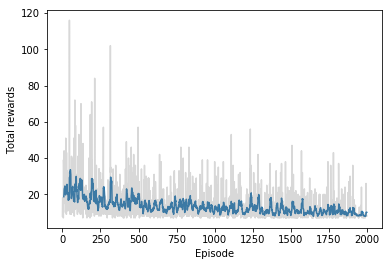

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

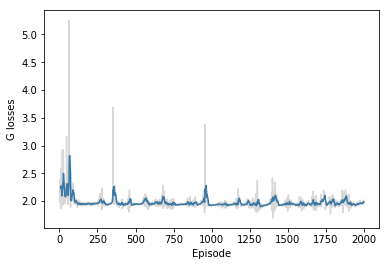

In [20]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

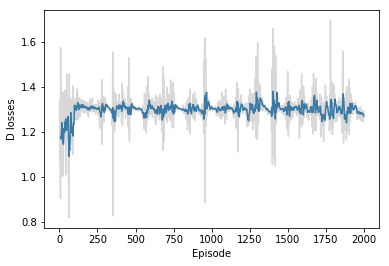

In [21]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.